In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [ ]:
import sys
sys.path.append("..")

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import scipy.stats as ss

In [7]:
from panco2 import PressureProfileFitter, results, utils
from make_sim_maps import make_sim_map_nika2
import mapview

(<Figure size 640x480 with 2 Axes>, <WCSAxesSubplot:>)

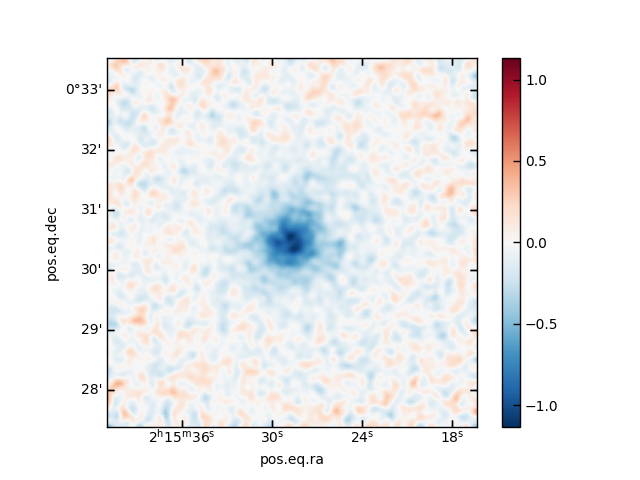

In [4]:
make_sim_map_nika2(0.9, 3e14, "nk2_actj0215_like.fits", map_size=6.1, conv=-12.0, zero=0.0)
mapview.fitsview("nk2_actj0215_like.fits", 1, smooth=1.0, scale=1000, imrange="sym")

(<Figure size 1000x500 with 4 Axes>,
 [<WCSAxesSubplot:xlabel='Right ascension (J2000)', ylabel='Declination (J200)'>,
  <WCSAxesSubplot:xlabel='Right ascension (J2000)', ylabel=' '>,
  <WCSAxesSubplot:xlabel='Right ascension (J2000)', ylabel=' '>])

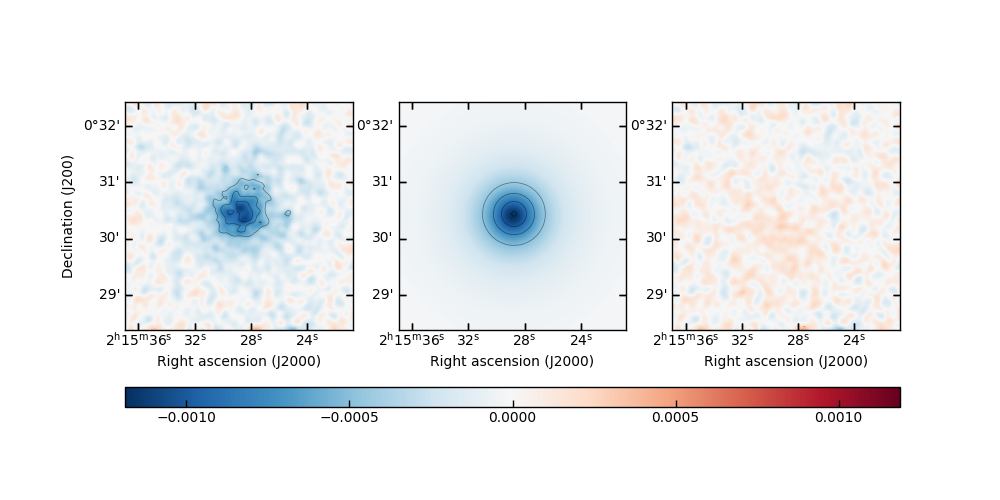

In [13]:
ppf = PressureProfileFitter(
    "nk2_actj0215_like.fits",
    1,
    2,
    0.865,
    M_500=3.5e14,
    map_size=4.0
)

r_bins = np.logspace(
    np.log10(ppf.cluster.arcsec2kpc(9.0)), np.log10(ppf.cluster.arcsec2kpc(180.0)), 5
)

ppf.define_model("binned", r_bins)
P_bins = utils.gNFW(ppf.model.r_bins, *ppf.cluster.A10_params)
par_vec = np.append(P_bins, [-12.0, 0.0])
par_dic = ppf.model.par_vec2dic(par_vec)

tf = Table.read("example_data/NIKA2/nk2_tf.fits")
ppf.add_filtering(beam_fwhm=18.0, k=tf["k"].to("arcmin-1").value, tf_k=tf["tf_2mm"].value)
ppf.define_priors(
    P_bins=[ss.loguniform(0.1 * P, 10.0 * P) for P in P_bins],
    conv=ss.norm(-12.0, 1.2),
    zero=ss.norm(0.0, 1e-4)
)

plt.close("all")
results.plot_data_model_residuals(ppf, par_vec=par_vec, lims="sym", smooth=1.0)